In [ ]:
!pip install imutils
!pip install wget
!pip install split-folders

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=e2d810af9490d4c2a5cf0561cfc95c7827774f99352197b1135610f07db8daa3
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8874fafa128effeb6605debcb819ed4fe9befbfe33379e4c8e95d03cb09a45ca
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# importing modules
import cv2
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Для Xception
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

In [ ]:
# Скачиваем нужный датасет
!kaggle datasets download -d vinayakshanawad/meat-freshness-image-dataset

Dataset URL: https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset
License(s): CC0-1.0
 94% 56.0M/59.4M [00:00<00:00, 163MB/s]
100% 59.4M/59.4M [00:00<00:00, 167MB/s]


In [ ]:
# Распаковка
!unzip meat-freshness-image-dataset.zip

Archive:  meat-freshness-image-dataset.zip
  inflating: Meat Freshness.v1-new-dataset.multiclass/README.dataset.txt  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1-_JPG.rf.65663691924ca0aede3884b863267c98.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-100-_JPG.rf.65e835ab6a2890785aade192d1e19549.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1000-_JPG.rf.d0f18a5c4075b50beeb7ee99036d491d.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1003-_JPG.rf.b410c33a04a1fba90032a9086d191d6d.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1005-_JPG.rf.404839308dfdce0228de77bf7458513a.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1009-_JPG.rf.1c4c304a072d95160d6ec26f0191344e.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-101-_JPG.rf.4c18cd9fd197ac72fa9dd68fcd00502f.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/F

In [ ]:
file_name = os.listdir('Meat Freshness.v1-new-dataset.multiclass/train/')
names = [i.split('-')[0] for i in file_name]
set(names)

{'FRESH', 'HALF', 'SPOILED', '_classes.csv'}

In [ ]:
# Кодируем имена классов
class_label_encoding = {
    'SPOILED': 0,
    'HALF': 1,
    'FRESH': 2
}

In [ ]:
train_x = []
train_y = []
test_x = []
test_y = []

In [ ]:
train_dir = 'Meat Freshness.v1-new-dataset.multiclass/train/'

for file_name in os.listdir(train_dir):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(train_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(class_label_encoding[class_name])

In [ ]:
import os
import shutil

In [ ]:
output_dir = 'Meat Freshness.v1-new-dataset.multiclass/train_sorted/'

# Создание директорий
class_dirs = {
    'FRESH': os.path.join(output_dir, 'Fresh'),
    'HALF': os.path.join(output_dir, 'Half-Fresh'),
    'SPOILED': os.path.join(output_dir, 'Spoiled')
}

for class_dir in class_dirs.values():
    os.makedirs(class_dir, exist_ok=True)

# Копирование файлов в соответствующие директории
for file_name in os.listdir(train_dir):
    class_name = file_name.split('-')[0]
    if class_name not in class_dirs:
        continue

    src_path = os.path.join(train_dir, file_name)
    dest_path = os.path.join(class_dirs[class_name], file_name)
    shutil.copy(src_path, dest_path)

print("Файлы успешно скопированы в соответствующие директории.")

Файлы успешно скопированы в соответствующие директории.


In [ ]:
fresh_dir = 'Meat Freshness.v1-new-dataset.multiclass/train_sorted/Fresh/'
for file_name in os.listdir(fresh_dir):
    img = cv2.imread(fresh_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(2)
half_dir = 'Meat Freshness.v1-new-dataset.multiclass/train_sorted/Half-Fresh/'
for file_name in os.listdir(half_dir):
    img = cv2.imread(half_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(2)
spoiled_dir ='Meat Freshness.v1-new-dataset.multiclass/train_sorted/Spoiled/'
for file_name in os.listdir(spoiled_dir):
    img = cv2.imread(spoiled_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(0)
val_dir = 'Meat Freshness.v1-new-dataset.multiclass/valid/'
for file_name in os.listdir(val_dir):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(val_dir+file_name).astype('float32') # read the colour image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    test_x.append(img)
    test_y.append(class_label_encoding[class_name])

In [ ]:
val_dir = 'Meat Freshness.v1-new-dataset.multiclass/valid/'
for file_name in os.listdir(val_dir):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img /= 255. # normalising pixel values
    test_x.append(img)
    test_y.append(class_label_encoding[class_name])

In [ ]:
print('shape of train x:', end=' ')
print(np.asarray(train_x).shape)
print('len of train y: '+ str(len(train_y)))

print('shape of test x:', end=' ')
print(np.asarray(test_x).shape)

print('len of test y: '+ str(len(test_y)))

shape of train x: 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3630,) + inhomogeneous part.

In [ ]:
# let's look at the class distribution
print('Train distribution')
print(pd.Series(train_y).value_counts())

print('Test distribution')
print(pd.Series(test_y).value_counts())

Train distribution
2    1980
0    1020
1     630
Name: count, dtype: int64
Test distribution
2    178
1    159
0    114
Name: count, dtype: int64


In [ ]:
# performing train test split with stratify enabled to maintain the class distribution
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=42, stratify=train_y)

# free up memory
del train_x
del train_y

In [ ]:
# performing one hot encoding and concerting list to numpy array before training
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3811,) + inhomogeneous part.

In [ ]:
model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3))) # each image shape - 416x416x3
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(3,'softmax')) # 3 classes

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 128)       0         
 g2D)                                                   

In [ ]:
# perform data augmentation
data_generator = ImageDataGenerator(rotation_range=15, zoom_range=0.1, vertical_flip=True, width_shift_range=0.1, height_shift_range=0.1)

history = model.fit(data_generator.flow(x_train,y_train,batch_size=128),validation_data=data_generator.flow(x_val, y_val, batch_size=32),epochs=50,callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])

In [ ]:
history = model.fit(data_generator.flow(x_train,y_train,batch_size=128),validation_data=data_generator.flow(x_val, y_val, batch_size=64),epochs=50,callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])

Epoch 1/50
10/10 [==============================] - 123s 12s/step - loss: 1.3452 - accuracy: 0.3559 - val_loss: 1.0579 - val_accuracy: 0.3761
Epoch 2/50
10/10 [==============================] - 121s 12s/step - loss: 1.0263 - accuracy: 0.4858 - val_loss: 1.2288 - val_accuracy: 0.3725
Epoch 3/50
10/10 [==============================] - 121s 12s/step - loss: 1.0514 - accuracy: 0.4638 - val_loss: 0.9502 - val_accuracy: 0.5963
Epoch 4/50
10/10 [==============================] - 121s 12s/step - loss: 0.8923 - accuracy: 0.5685 - val_loss: 0.8398 - val_accuracy: 0.6110
Epoch 5/50
10/10 [==============================] - 120s 12s/step - loss: 0.8067 - accuracy: 0.6433 - val_loss: 0.7178 - val_accuracy: 0.6606
Epoch 6/50
10/10 [==============================] - 120s 12s/step - loss: 0.7160 - accuracy: 0.6622 - val_loss: 0.6397 - val_accuracy: 0.7119
Epoch 7/50
10/10 [==============================] - 121s 12s/step - loss: 0.6114 - accuracy: 0.7362 - val_loss: 0.5610 - val_accuracy: 0.7083
Epoch 

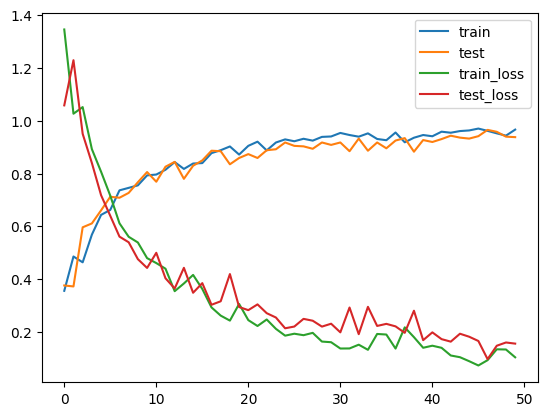

In [ ]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

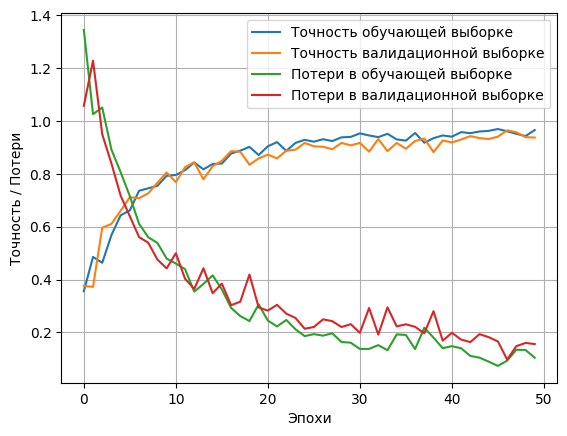

In [ ]:
# Построение графиков
pyplot.plot(history.history['accuracy'], label='Точность обучающей выборке')
pyplot.plot(history.history['val_accuracy'], label='Точность валидационной выборке')
pyplot.plot(history.history['loss'], label='Потери в обучающей выборке')
pyplot.plot(history.history['val_loss'], label='Потери в валидационной выборке')

# Подписи осей
pyplot.xlabel('Эпохи')
pyplot.ylabel('Точность / Потери')

# Легенда и отображение графика
pyplot.legend()
#pyplot.title('Training and Validation Metrics')
pyplot.grid(True)
pyplot.show()

In [ ]:
loss, acc = model.evaluate(np.array(test_x), to_categorical(test_y))
print('Testing accuracy on unseen data:', round(acc*100,3))
print('Testing loss on unseen data:', round(loss,3))

15/15 [==============================] - 8s 557ms/step - loss: 21.0010 - accuracy: 0.3947
Testing accuracy on unseen data: 39.468
Testing loss on unseen data: 21.001


In [ ]:
model.save('trained_model_50_epochs_eval.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 128)       0         
 g2D)                                                   

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
test_x1 = np.array(test_x)
print(test_x1.shape)

(451, 128, 128, 3)


In [ ]:
test_gen = data_generator.flow(test_x1, test_y, batch_size=32)

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (451, 128, 128, 3), y.shape = (1353,)

In [ ]:
y_pred = model.predict(test_gen)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_y,toClass(y_pred))

15/15 [==============================] - 9s 565ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1353, 451]

In [ ]:
print(cm)

[[  0   0 114]
 [  0   0 159]
 [  0   0 178]]


In [ ]:
import matplotlib.pyplot as plt

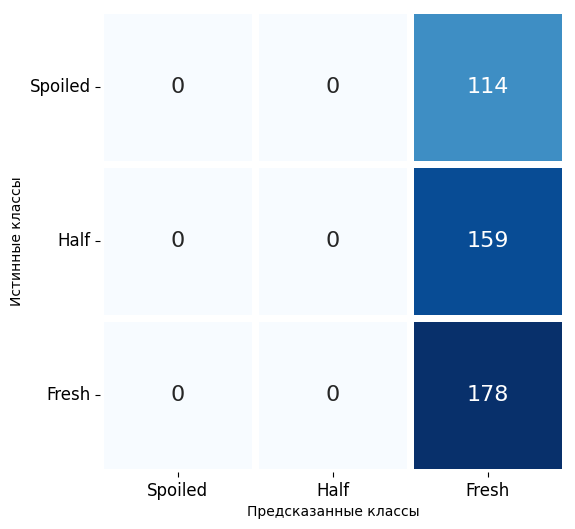

In [ ]:
df1 = pd.DataFrame(columns=["Spoiled","Half","Fresh"], index= ["Spoiled","Half","Fresh"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Blues", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Предсказанные классы")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Истинные классы")
#plt.title("Матрица ошибок", size = 12)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Получаем предсказания
y_pred_probs = model.predict(np.array(test_x))
y_pred = np.argmax(y_pred_probs, axis=1)

# Преобразуем test_y в метки классов, если это необходимо
y_test = np.array(test_y)

# Вычисляем F1-оценку
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


15/15 [==============================] - 9s 564ms/step
F1 Score: 0.2234


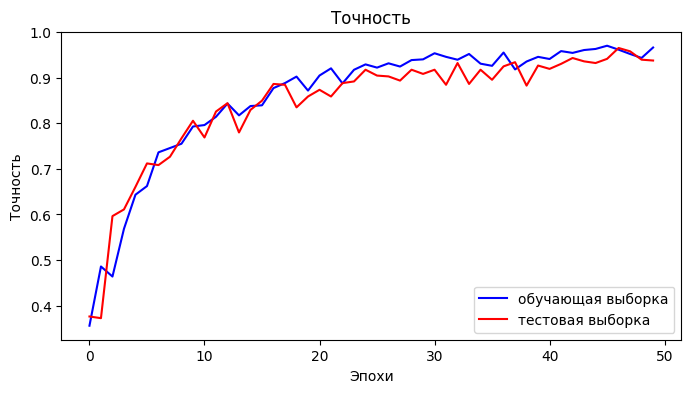

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))
plt.figure(figsize=(8,4))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend(['обучающая выборка', 'тестовая выборка'], loc='lower right')

Text(0.5, 0, 'Эпохи')

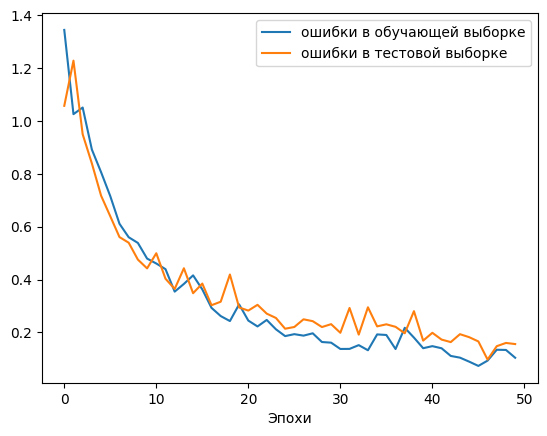

In [ ]:
pyplot.plot(history.history['loss'], label='ошибки в обучающей выборке')
pyplot.plot(history.history['val_loss'], label='ошибки в тестовой выборке')
pyplot.legend()
plt.xlabel('Эпохи')

In [ ]:
# Функция для отображения изображения с предсказанием и истинным классом

def display_prediction(image, true_label, predicted_label, predicted_probs):
    # Округляем вероятности до двух знаков после запятой
    predicted_probs = np.round(predicted_probs, 2)
    plt.imshow(image)
    plt.title(f'True: {true_label}, Predicted: {predicted_label}\nProbabilities: {predicted_probs}')
    plt.axis('off')
    plt.show()

# Получаем случайный индекс
random_idx = np.random.randint(0, len(test_x))

# Извлекаем случайное изображение и его истинный класс
random_image = test_x[random_idx]
true_label = test_y[random_idx]

# Добавляем ось для батча и делаем предсказание
random_image_batch = np.expand_dims(random_image, axis=0)
predicted_probs = model.predict(random_image_batch)
predicted_label = np.argmax(predicted_probs, axis=1)[0]

# Маппинг числовых меток классов на текстовые метки
label_mapping = {0: 'SPOILED', 1: 'HALF', 2: 'FRESH'}
true_label_text = label_mapping[true_label]
predicted_label_text = label_mapping[predicted_label]

# Отображаем изображение с предсказанием
display_prediction(random_image, true_label_text, predicted_label_text, predicted_probs[0])

1/1 [==============================] - 0s 46ms/step


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
from tensorflow.keras.models import load_model

# Укажите путь к сохранённой модели
model = load_model('/content/trained_model_50_epochs.h5')


In [ ]:
test_dir = '/content/Meat Freshness.v1-new-dataset.multiclass/valid'  # Укажите путь к папке с тестовыми данными

test_x = []  # Для хранения изображений
test_y = []  # Для хранения меток классов

# Словарь кодирования классов
class_label_encoding = {
    'SPOILED': 0,
    'HALF-FRESH': 1,
    'FRESH': 2
}

# Проходим по файлам в папке valid
for file_name in os.listdir(test_dir):
    # Проверяем, является ли файл изображением
    if not file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        print(f"Пропущен некорректный файл: {file_name}")
        continue

    # Определяем класс по имени файла
    if file_name.startswith("FRESH"):
        class_name = "FRESH"
    elif file_name.startswith("HALF-FRESH"):
        class_name = "HALF-FRESH"
    elif file_name.startswith("SPOILED"):
        class_name = "SPOILED"
    else:
        print(f"Пропущен файл с неизвестным классом: {file_name}")
        continue

    # Полный путь к изображению
    file_path = os.path.join(test_dir, file_name)

    # Читаем изображение
    img = cv2.imread(file_path)
    if img is None:
        print(f"Ошибка чтения изображения: {file_path}")
        continue

    # Преобразуем изображение (цветовой формат и размер)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
    img = img.astype('float32') / 255.0  # Нормализация

    # Добавляем в списки
    test_x.append(img)
    test_y.append(class_label_encoding[class_name])

# Преобразуем в массивы
test_x = np.array(test_x)
test_y = to_categorical(test_y)  # One-hot encoding
print(f"Загружено {len(test_x)} изображений.")


Пропущен некорректный файл: _classes.csv
Загружено 451 изображений.


In [ ]:
loss, acc = model.evaluate(test_x, test_y)
print(f"Точность на тестовой выборке: {acc * 100:.2f}%")
print(f"Потери на тестовой выборке: {loss:.4f}")


15/15 [==============================] - 9s 564ms/step - loss: 0.1110 - accuracy: 0.9557
Точность на тестовой выборке: 95.57%
Потери на тестовой выборке: 0.1110


15/15 [==============================] - 9s 571ms/step


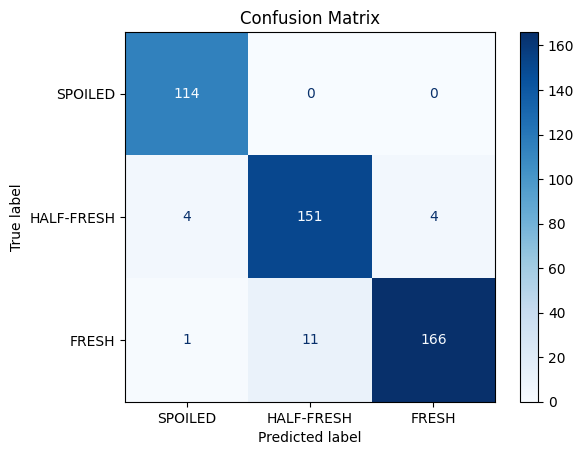

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Предсказания модели
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)  # Конвертируем вероятности в классы

# Истинные метки классов
y_true_classes = np.argmax(test_y, axis=1)

# Создаем матрицу ошибок
cm = confusion_matrix(y_true_classes, y_pred_classes)
# Отображаем матрицу ошибок
class_names = ['SPOILED', 'HALF-FRESH', 'FRESH']  # Имена классов
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


15/15 [==============================] - 9s 571ms/step


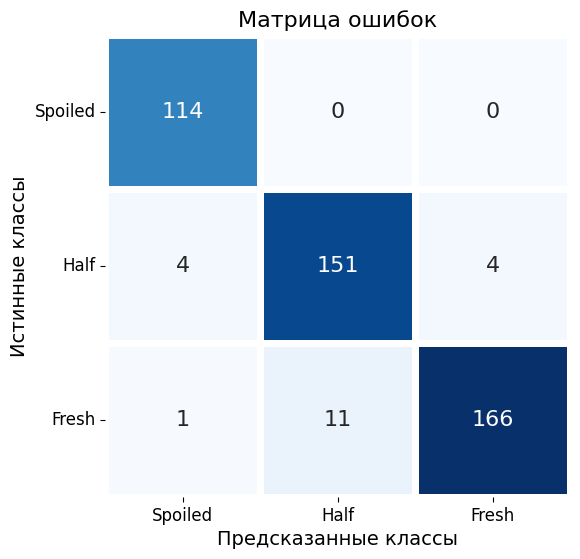

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Предсказания модели
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)  # Конвертируем вероятности в классы

# Истинные метки классов
y_true_classes = np.argmax(test_y, axis=1)

# Создаем матрицу ошибок
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Создаем DataFrame для отображения
class_names = ["Spoiled", "Half", "Fresh"]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)




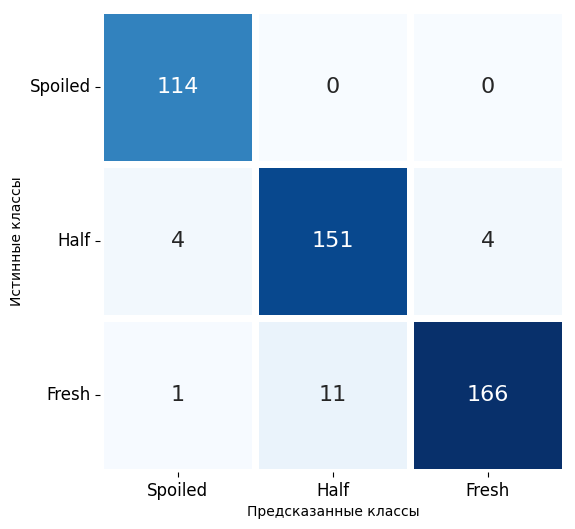

In [ ]:
# Построение heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(df_cm, annot=True, fmt=".0f", cmap="Blues", linewidths=5, cbar=False, annot_kws={"size": 16})
plt.xlabel("Предсказанные классы", fontsize=10)
plt.ylabel("Истинные классы", fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
#plt.title("Матрица ошибок", fontsize=16)
plt.show()

In [ ]:
print(cm)

[[114   0   0]
 [  4 151   4]
 [  1  11 166]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Истинные метки и предсказания
y_true = np.concatenate([
    [0] * 114,  # 114 верных "Spoiled"
    [1] * 4,    # 4 неверных "Half" как "Spoiled"
    [2] * 1,    # 1 неверных "Fresh" как "Spoiled"
    [1] * 151,  # 151 верных "Half"
    [0] * 4,    # 4 неверных "Spoiled" как "Half"
    [2] * 11,   # 11 неверных "Fresh" как "Half"
    [2] * 166,  # 166 верных "Fresh"
    [1] * 4,    # 4 неверных "Half" как "Fresh"
    [0] * 0     # 0 неверных "Spoiled" как "Fresh"
])

y_pred = np.concatenate([
    [0] * 114,  # Предсказания верны для "Spoiled"
    [0] * 4,    # Неверно классифицированы как "Spoiled"
    [0] * 1,    # Неверно классифицированы как "Spoiled"
    [1] * 151,  # Предсказания верны для "Half"
    [1] * 4,    # Неверно классифицированы как "Half"
    [1] * 11,   # Неверно классифицированы как "Half"
    [2] * 166,  # Предсказания верны для "Fresh"
    [2] * 4,    # Неверно классифицированы как "Fresh"
    [2] * 0     # Неверно классифицированы как "Fresh"
])

# F1-score для каждого класса
f1 = f1_score(y_true, y_pred, average=None)
print("F1-score для каждого класса:", f1)

# Средний F1-score (взвешенный)
f1_weighted = f1_score(y_true, y_pred, average="weighted")
print("Средний F1-score (взвешенный):", f1_weighted)


F1-score для каждого класса: [0.96202532 0.92923077 0.95402299]
Средний F1-score (взвешенный): 0.9474346628648075


1/1 [==============================] - 0s 47ms/step


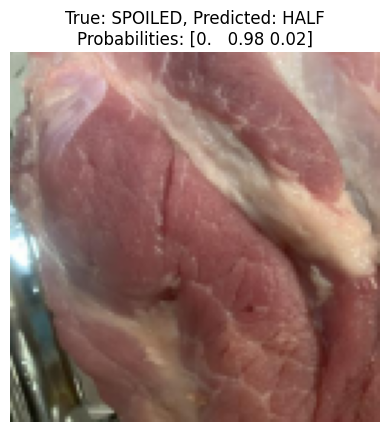

In [ ]:
def display_prediction(image, true_label, predicted_label, predicted_probs):
    # Проверяем диапазон значений изображения
    if image.max() <= 1:
        # Если изображение нормализовано, преобразуем в диапазон [0, 255]
        image = (image * 255).astype('uint8')
    elif image.dtype != 'uint8':
        # Если изображение не в формате uint8, конвертируем его
        image = image.astype('uint8')

    # Округляем вероятности до двух знаков после запятой
    predicted_probs = np.round(predicted_probs, 2)
    plt.imshow(image.astype('uint8'))  # Убедитесь, что изображение в формате uint8
    plt.title(f'True: {true_label}, Predicted: {predicted_label}\nProbabilities: {predicted_probs}')
    plt.axis('off')
    plt.show()

import numpy as np

# Получаем случайный индекс
random_idx = np.random.randint(0, len(test_x))

# Извлекаем случайное изображение и его истинный класс
random_image = test_x[random_idx]
true_label = test_y[random_idx]

# Добавляем ось для батча и делаем предсказание
random_image_batch = np.expand_dims(random_image, axis=0)
predicted_probs = model.predict(random_image_batch)  # Предсказание вероятностей
predicted_label = np.argmax(predicted_probs, axis=1)[0]  # Определяем предсказанный класс

# Маппинг числовых меток классов на текстовые метки
label_mapping = {0: 'SPOILED', 1: 'HALF', 2: 'FRESH'}

# Убедитесь, что true_label и predicted_label — это скаляры
true_label = test_y[random_idx] if isinstance(test_y[random_idx], (int, np.integer)) else test_y[random_idx][0]
predicted_label = np.argmax(predicted_probs, axis=1)[0] if isinstance(np.argmax(predicted_probs, axis=1)[0], (int, np.integer)) else np.argmax(predicted_probs, axis=1)[0]

# Маппинг числовых меток классов на текстовые метки
true_label_text = label_mapping[true_label]
predicted_label_text = label_mapping[predicted_label]

# Отображаем изображение с предсказанием
display_prediction(random_image, true_label_text, predicted_label_text, predicted_probs[0])


1/1 [==============================] - 0s 47ms/step


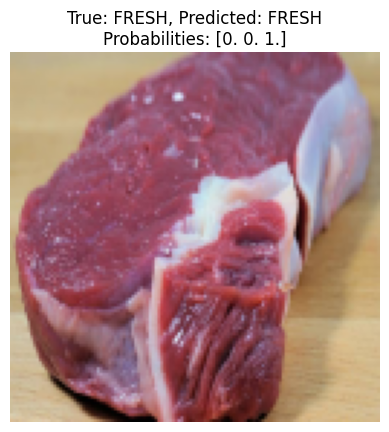

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Функция для извлечения истинного класса из имени файла
def extract_true_label(file_name):
    for label in ['SPOILED', 'HALF', 'FRESH']:
        if label in file_name.upper():
            return label
    return "UNKNOWN"

# Функция для загрузки изображения и его предобработки
def preprocess_image(image_path, target_size=(128, 128)):
    # Загрузка изображения
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение по пути: {image_path}")

    # Конвертация BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Изменение размера до целевого
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    # Нормализация
    image = image / 255.0  # Приведение значений в диапазон [0, 1]

    return image

# Функция для отображения предсказания
def display_prediction(image, true_label, predicted_label, predicted_probs):
    predicted_probs = np.round(predicted_probs, 2)
    plt.imshow(image)
    plt.title(f'True: {true_label}, Predicted: {predicted_label}\nProbabilities: {predicted_probs}')
    plt.axis('off')
    plt.show()

# Путь к изображению
image_path = "/content/FRESH-1.jpg"  # Замените на путь к вашему изображению

# Извлечение истинного класса из имени файла
true_label_text = extract_true_label(image_path)

# Предобработка изображения
input_image = preprocess_image(image_path)

# Добавление оси батча
input_image_batch = np.expand_dims(input_image, axis=0)

# Выполнение инференса
predicted_probs = model.predict(input_image_batch)  # Предсказание вероятностей
predicted_label = np.argmax(predicted_probs, axis=1)[0]  # Определение предсказанного класса

# Маппинг числовых меток классов на текстовые метки
label_mapping = {0: 'SPOILED', 1: 'HALF', 2: 'FRESH'}
predicted_label_text = label_mapping[predicted_label]

# Визуализация результата
display_prediction(input_image, true_label_text, predicted_label_text, predicted_probs[0])
